<a href="https://colab.research.google.com/github/felipe-parodi/QuantTools4Neuro/blob/master/KinematicPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinematic Analysis for 3D Pose Data

### Import packages

In [ ]:
import numpy as np
import pandas as pd
import cv2,os,pickle
from IPython.display import Image, display
import csv 
import glob
import json

import statsmodels.api as sm # local regression filter
from scipy import signal
from scipy import fftpack # fourier-filtered
from scipy.signal import savgol_filter

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [ ]:
# If google drive:
from google.colab import drive
drive.mount('/content/gdrive')

### Load mmpose inference data

In [ ]:
# Fxns for loading data:
def loaddatpkl(filename):
    output = open(filename,'rb')
    data = pickle.load(output)
    output.close()
    return data

def savedatapkl(path,data,protocol = 4):
    output = open(path,'wb')
    pickle.dump(data,output,protocol = protocol)
    output.close()

### Load AIST++ Dataset

In [ ]:
# Load AIST++ 3D data:
# Link to data: https://drive.google.com/drive/folders/1WCkTmWX6v4DLQj1sMyh7Xs-IhTE9U3Fj?usp=sharing


In [ ]:
# Convert AIST++ 3D data to DeepLabCut formatting:


### DeepLabCut kinematic functions

In [ ]:
# 0. Import packages:
try: 
  import dlc2kinematics
except:
  !pip install dl2ckinematics
  import dl2ckinematics

import deeplabcut #whatever fxn allows us to convert csv2h5
%matplotlib notebook
from dl2kinematics import Visualizer3D

In [ ]:
# 0. Transfer frames and config.yaml to gdrive

# 1. Convert pickle file to deeplabcut formatted csv:


# csv name should be: CollectedData_Felipe.csv

In [ ]:
# 2. Convert DLC csv to DLC h5:
deeplabcut.convertcsv2h5('path2config.yaml')

In [ ]:
# 3. Load 2D or 3D data:
config = '.../config.yaml'
# dlc_2d_file = '...'
dlc_3d_file = '...'

df, bodyparts, scorer = dlc2kinematics.load_data(dlc_3d_file)
df.head(5)

In [ ]:
# 4. Compute velocity, speed, and acceleration for all body parts:
df_vel = dlc2kinematics.compute_velocity(df,bodyparts=['all'], 
                                         filter_window=3, 
                                         order=1) # filter smooths data

df_speed = dlc2kinematics.compute_speed(df,bodyparts=['all'],
                                        filter_window=3, order=1)

df_acc = dlc2kinematics.compute_acceleration(df, bodyparts=['all'])

df_vel_bodypart = dlc2kinematics.compute_velocity(df, bodyparts = ['bodypart'])

# 5. Plot x/y/z velocity of bodypart and original position data:
%matplotlib inline
dlc2kinematics.plot_velocity(df[scorer]['specificbodypart'],df_vel_bodypart)

#### Joint angle analysis

insert numbered drawing of landmarks here

In [ ]:
# 5. Compute joint angles:

# Define dictionary of joints:
joints_dict = {}

joints_dict['L-ShoulderElbowWrist'] = ['L_shoulder', 'L_elbow', 'L_wrist'] # [6,8,10]
joints_dict['R-ShoulderElbowWrist'] = ['R_shoulder', 'R_elbow', 'R_wrist'] # [7,9,11]
joints_dict['L-EarShoulderElbow'] = ['L_ear','L_shoulder', 'L_elbow'] # [4,6,8]
joints_dict['R-EarShoulderElbow'] = ['R_ear','R_shoulder', 'R_elbow'] # [5,7,9]
joints_dict['L-ShoulderHipKnee'] = ['L_shoulder', 'L_hip', 'L_knee'] # [6,12,14]
joints_dict['R-ShoulderHipKnee'] = ['R_shoulder', 'R_hip', 'R_knee'] # [7,13,15]
joints_dict['L-HipKneeAnkle'] = ['L_hip', 'L_knee', 'L_ankle'] # [12,14,16]
joints_dict['R-HipKneeAnkle'] = ['R_hip', 'R_knee', 'R_ankle'] # [13,15,17]
joints_dict['L-ElbowShoulder-RShoulder'] = ['L_elbow', 'L_shoulder', 'R_shoulder'] # [8,6,7]
joints_dict['R-ElbowShoulder-LShoulder'] = ['R_elbow', 'R_shoulder', 'L_shoulder'] # [9,7,6]
joints_dict['L-ElbowShoulderHip'] = ['L_elbow', 'L_shoulder', 'L_hip'] # [8,6,12]
joints_dict['R-ElbowShoulderHip'] = ['R_elbow', 'R_shoulder', 'R_hip'] # [9,7,13]
joints_dict['L-KneeHip-RHip'] = ['L_knee', 'L_hip', 'R_hip'] # [14,12,13]
joints_dict['R-KneeHip-LHip'] = ['R_knee', 'R_hip', 'L_hip'] # [15,13,12]
joints_dict['R-Eye-LEyeEar'] = ['R_eye', 'L_eye', 'L_ear'] # [3,2,4]
joints_dict['L-Eye-REyeEar'] = ['L_eye', 'R_eye', 'R_ear'] # [2,3,5]
joints_dict['L-EarEye-Nose'] = ['L_ear', 'L_eye', 'Nose'] # [4,2,1]
joints_dict['R-EarEye-Nose'] = ['R_ear', 'R_eye', 'Nose'] # [5,3,1]
joints_dict['L-EarShoulderHip'] = ['L_ear', 'L_shoulder', 'L_hip'] # [4,6,12]
joints_dict['R-EarShoulderHip'] = ['R_ear', 'R_shoulder', 'R_hip'] # [5,7,13]
joints_dict['L-EarShoulder-RShoulder'] = ['L_ear', 'L_shoulder', 'R_shoulder'] # [4,6,7]
joints_dict['R-EaShoulder-LShoulder'] = ['R_ear', 'R_shoulder', 'L_shoulder'] # [5,7,6]
joints_dict['L-ShoulderHip-RHip'] = ['L_shoulder', 'L_hip', 'R_hip'] # [6,12,13]
joints_dict['R-ShoulderHip-LHip'] = ['R_shoulder', 'R_hip', 'L_hip'] # [7,13,12]
joints_dict['R-Shoulder-LShoulderHip'] = ['R_shoulder', 'L_shoulder', 'L_hip'] # [7,6,12]
joints_dict['L-Shoulder-RShoulderHip'] = ['L_shoulder', 'R_shoulder', 'R_hip'] # [6,7,13]

joint_angles = dlc2kinematics.compute_joint_angles(df,joints_dict,
                                                   dropnan=True, smooth=True,
                                                   save=True,
                                                   destfolder='../..',
                                                   smooth=True, # savgol filter
                                                   filter_window=3,
                                                   order=1)

# Plot joint angles:
dlc2kinematics.plot_joint_angles(joint_angles)

In [ ]:
# 6. Compute joint angle velocity and acceleration:

joint_vel = dlc2kinematics.compute_joint_velocity(joint_angles,
                                                  save=True,
                                                  destfolder='../..',
                                                  output_filename='...')

joint_acc = dlc2kinematics.compute_joint_acceleration(joint_angles,
                                                      save=True,
                                                      destfolder='../',
                                                      output_filename='...')


In [ ]:
# 7. Compute correlation between joint angle velocities (or acc):

# i.e., which joints AREN'T highly correlated?
joint_vel_corr = dlc2kinematics.compute_correlation(joint_vel,
                                                plot=True,
                                                colormap='viridis')

In [ ]:
# 8. Compute PCA of joint angle features:

pca_vel = dlc2kinematics.compute_pca(joint_vel, plot=True)
pca_accel = dlc2kinematics.compute_pca(joint_acc, plot=True)

print("The number of principal components is: %s"%pca.n_components_)
print(np.cumsum(pca.explained_variance_ratio_))

### Ben's kinematic functions

In [ ]:
#function to make np.arrays of x y and z for each joint for a timeframe
def df_to_specjoints(jointdf, startframe, endframe, jointidxs, skipcol=2):
  jarray = np.empty([len(jointidxs), endframe-startframe, 3])
  for i, j in enumerate(jointidxs):
    jarray[i] = jointdf.iloc[startframe:endframe, skipcol+j:skipcol+j+3]
  return jarray

#this one gets all the joints
def df_to_array(jointdf, startframe, endframe, numjoints=29, skipcol=2):
  #skip non-pose data columns and non-relevant frames (rows) 
  jarray = np.empty([29, endframe-startframe, 3])
  for i in range(numjoints):
    jarray[i] = jointdf.iloc[startframe:endframe, (skipcol+i):(skipcol+i+3)]
  return jarray


In [ ]:
#0 Preliminary movement quantities

#function for getting deriv by raw diff calculation / dt (framerate)
def get_deriv(jointdata, timeframe, dt=1/180):
    
    #compute deriv. Jointdata dimensions are [joints(29), frames (3394), spacedim(3)] 
    deriv =  (jointdata[:, 1:] - jointdata[:, :-1]) / dt 
                                                          #could skip 1/2 the points for speed 
    return deriv

def lowess (jointdata, numframes=45):
    timeframe = np.arange(len(jointdata))
    smoothed = sm.nonparametric.lowess(
        exog=timeframe, endog=jointdata, frac=numframes/timeframe[-1], return_sorted=False)
    return smoothed

#local regression filter

def lowess (jointdata, timeframe, numframes=45):
    smoothed = sm.nonparametric.lowess(exog=timeframe, endog=jointdata, frac=numframes/len(timeframe), return_sorted=False)
    return smoothed

#savitsky-golay filter

def savgol (jointdata, window=45, order=2):
  smoothed = savgol_filter(jointdata, window, order, mode='nearest')
  return smoothed

# kalman filter 
from filterpy.kalman import KalmanFilter, predict, update

#Use above function in loop with lowess to produce each joint's motion parameters /frame

def get_moveparam(posdata, timeframe, dt=1/180):

  rawvel = get_deriv(posdata, timeframe)
  vel = np.empty_like(rawvel)
  #loop through joints, smooth each spatial dimension in each joint 
  for index, joint in enumerate(rawvel):
    for dim in range(3):
        vel[index, ..., dim] = lowess(joint[:, dim])

  #repeat for accel
  rawacc = get_deriv(vel, timeframe)  
  accel = np.empty_like(rawacc)
  for index, joint in enumerate(rawacc):
    for dim in range(3):
        accel[index, ..., dim] = lowess(joint[:, dim])

  #repeat for jerk
  rawjerk = get_deriv(accel, timeframe)
  jerk = np.empty_like(rawjerk)
  for index, joint in enumerate(rawjerk):
    for dim in range(3):
        jerk[index, ..., dim] = lowess(joint[:, dim])

  return posdata, vel, accel, jerk

In [ ]:
#1 Motionparam averages and variances

def get_means(moveparam):

  jointnum = len(moveparam[0])
  mean_vels = np.empty_like(moveparam[1])
  mean_accels = np.empty_like(moveparam[2])
  mean_jerks = np.empty_like(moveparam[3])
  
  for j in range(jointnum):
    mean_vels[j] = np.mean(moveparam[1][j], axis=0)
    mean_accels[j] = np.mean(moveparam[2][j], axis=0)
    mean_jerks[j] = np.mean(moveparam[3][j], axis=0)

  totalmeanvel = np.mean(mean_vels)
  totalmeanaccel = np.mean(mean_accels)
  totalmeanjerk = np.mean(mean_jerks)

  means = [mean_vels, mean_accels, mean_jerks]
  totals = [totalmeanvel, totalmeanaccel, totalmeanjerk]

  return means, totals

def get_vars(moveparam):

  jointnum = len(moveparam[0])
  var_velocities = np.empty_like(moveparam[1])
  var_accelerations = np.empty_like(moveparam[2])
  var_jerks = np.empty_like(moveparam[3])
  
  for j in range(jointnum):
    var_velocities = np.var(moveparam[1][j], axis=0)
    var_accelerations = np.var(moveparam[2][j], axis=0)
    var_jerks = np.var(moveparam[3][j], axis=0)

  totalvarvel = np.mean(var_velocities)
  totalvaraccel = np.mean(var_accelerations)
  totalvarjerk = np.mean(var_jerks)

  vars = [var_velocities, var_accelerations, var_jerks]
  totals = [totalvarvel, totalvaraccel, totalvarjerk]

  return vars, totals

In [ ]:
#2: Total motion / acceleration / jerk. Square and integrate movement values

def get_paramsums(moveparam):
  
  sums = []

  for joint in moveparam:
    sums.append(np.sqrt(np.sum(joint**2, axis=1)))

  totalsum = np.sum(sums, axis=1)

  return totalsum, sums

In [ ]:
#3:  Level distribution - var(2*sacrumpos+crownpos ydim)

def get_levels(sacrumpos, crownpos):

  levelovertime = []
  for i in range(len(sacrumpos)):
    levelovertime.append(2*sacrumpos[i,1] + crownpos[i,1])

  levelhist = sorted(levelovertime)  

  return levelovertime, levelhist

#4:  Expandedness - sum distance from sacrum (/numjoints) 
# variance, and total change

def get_expandedness(jointdata, sacrum):
    
    distancefromsacrum = [np.sqrt((j - sacrum)**2) for j in jointdata]
    meanfromsacrum = [j.mean(axis=1) for j in distancefromsacrum]

    return distancefromsacrum, meanfromsacrum

In [ ]:
#:   How is motion/accel/jerk distributed? Asymmetries
#5  In vs out - (shoulders+hips)/(knees+elbows+hands) 
#6  Side vs side - (rhand-lhand)+(rfoot-lfoot)+(relbow-lelbow)+(rknee-lknee)
#7  Top vs Bottom - (shoulderselbowshands - hipskneesfeet) 

#5 idxbodyparts is a list of ints indexing the relevant joints in the moveparam array
def Asym_InOut(moveparam, idxshoulderships, idxkneeselbowshands):
  
  Insums = []
  Outsums = []
  
  for i in idxshoulderships:
    Insums.append(np.sqrt(np.sum(moveparam[i]**2)))

  for i in idxkneeselbowshands:
    Outsums.append(np.sqrt(np.sum(moveparam[i]**2)))

  Insums = np.sum(Insums)
  Outsums = np.sum(Outsums)

  Ratio = Insums / Outsums

  return Ratio

#6
def Asym_Sides(moveparam, idxrlimbs, idxllimbs):

  Rsums = []
  Lsums = []

  for i in idxrlimbs:
    Rsums.append(np.sqrt(np.sum(moveparam[i]**2)))

  for i in idxllimbs:
    Lsums.append(np.sqrt(np.sum(moveparam[i]**2)))

  Rsums = np.sum(Rsums)
  Lsums = np.sum(Lsums)

  Rimbal = Rsums / Lsums

  return Rimbal

#7
def Asym_TopBot(moveparam, idxtop, idxbot):
  
  Topsums = []
  Botsums = []
  
  for i in idxtop:
    Topsums.append(np.sqrt(np.sum(moveparam[i]**2)))

  for i in idxbot:
    Botsums.append(np.sqrt(np.sum(moveparam[i]**2)))

  Topsums = np.sum(Topsums)
  Botsums = np.sum(Botsums)

  Ratio = Topsums / Botsums

  return Ratio

In [ ]:
#8: joint-rank-weighted motion 
#total motion of joint multiplied by how many other joints move more than it (xscaling factor)

def Wholemove_factor(moveparam, scalefactor=1.1):

  scaledsum = 0
  sums = get_parsum(moveparam)[1]
  rankedsums = sorted(sums)[::-1]

  for idx, sum in enumerate(rankedsums):
    scale = idx * scalefactor
    scaledsum += scale * sum

  return scaledsum

  #instead just get some measure of entropy per movement parameter per joint or limb

#function for getting distances from sacrum

def from_sacrum(jointdata, sacrum):
    distancefromsacrum = []
    for j in jointdata:
        distancefromsacrum.append(j - sacrum)
    return distancefromsacrum

In [ ]:
#old moveparam code

# def old_get_moveparam(posdata, timeframe, dt=1/180):

#     rawvelocity = get_deriv(posdata, timeframe)
#     velocity = np.empty_like(rawvelocity)

#     #loop through joints, smooth each spatial dimension in each joint 
#     for index, joint in enumerate(rawvelocity):
#       velocity[index] = np.stack((lowess(joint[:,0]),
#                                   lowess(joint[:,1]),
#                                   lowess(joint[:,2])),axis=1)
    
#     #repeat for accel
#     rawaccel = get_deriv(velocity, timeframe)  
#     acceleration = np.empty_like(rawaccel)

#     for index, joint in enumerate(rawaccel):
#       acceleration[index] = np.stack((lowess(joint[:,0]),
#                                       lowess(joint[:,1]),
#                                       lowess(joint[:,2])),axis=1) 
      
#     #repeat for jerk
#     rawjerk = get_deriv(acceleration, timeframe)
#     jerk = np.empty_like(rawjerk)

#     for index, joint in enumerate(rawjerk):
#       jerk[index] = np.stack((lowess(joint[:,0]),
#                               lowess(joint[:,1]),
#                               lowess(joint[:,2])),axis=1)
  
#     return posdata, velocity, acceleration, jerk

# averages from above code
def get_meanmove(movedata):
  means = []
  for i in movedata:
    for dim in range(3):
      means.append(np.mean(i[:,dim]))
  means = np.array(means).reshape(4,3)
  return means

def get_varmove(movedata):
  vars = []
  for i in movedata:
    for dim in range(3):
      vars.append(np.var(i[:,dim]))
  vars = np.array(vars).reshape(4,3)
  return vars

In [ ]:
# animate plot of joints
#init and update functions to be called for animation. Update gets the plot at a frame
def init():
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):

    x1 = [choreo2df.iloc[startframe+frame, j] for j in range (2,89,3)]
    y1 = [choreo2df.iloc[startframe+frame, j] for j in range (3,89,3)]

    x2 = [choreo3df.iloc[startframe+frame, j] for j in range (2,89,3)]
    y2 = [choreo3df.iloc[startframe+frame, j] for j in range (3,89,3)]
      
    xlist = [x1, x2]
    ylist = [y1, y2]

    #for index in range(0,1):
    for lnum,line in enumerate(lines):
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 

    return lines


In [ ]:
#functions for creating reverse dance - adds reverse track of 1 joint / 3dim
def flipitandreverseit(joint, timeframe):
    
    #create doubled time vector
    doubletime = choreotime.copy()
    for i in range(len(timeframe)):
        doubletime.append(timeframe[-1] + timeframe[i])
    
    #initialize reversed joint and jointandback data
    revjoint =  pd.DataFrame(index=range(len(timeframe)),
                            columns=['x_rev', 'y_rev', 'z_rev'])
    jointandback = pd.DataFrame(index=range(len(doubletime)),
                            columns=['x_pos', 'y_pos', 'z_pos'])
    
    #create reversed jointpos vectors
    revjoint.x_rev = list(joint.iloc[:,0])[::-1]
    revjoint.y_rev = list(joint.iloc[:,1])[::-1]
    revjoint.z_rev = list(joint.iloc[:,2])[::-1]
    
    #append reversed jointpos data to fwd jointpos data
    for i in range(len(timeframe)):
        jointandback.iloc[i,0] = joint.iloc[i,0]
        jointandback.iloc[i,1] = joint.iloc[i,1]
        jointandback.iloc[i,2] = joint.iloc[i,2]
        jointandback.iloc[len(timeframe)+i,0] = revjoint.x_rev[i]
        jointandback.iloc[len(timeframe)+i,1] = revjoint.y_rev[i]
        jointandback.iloc[len(timeframe)+i,2] = revjoint.z_rev[i]
        
    return jointandback, doubletime

In [ ]:
#autosk learn
#xg boost
# - predict the genre
#get comparable sum of non expert and predict that class 

#see where it gets thing wrong

In [ ]:
#import dance dataframe

choreo2df = pd.read_csv('gdrive/MyDrive/Research/DanceSci/MITpilot/MITdance2_neat.csv')
choreo3df = pd.read_csv("gdrive/MyDrive/Research/DanceSci/MITpilot/MITdance3_neat.csv") 
choreo2df.head()

#units are mm

,Frame,Time_sec,crown_x,crown_y,crown_z,rtemple_x,rtemple_y,rtemple_z,L_shoulder_x,L_shoulder_y,...,spine4_z,spine5_x,spine5_y,spine5_z,occiput_x,occiput_y,occiput_z,sacrum_x,sacrum_y,sacrum_z
0,0,0.000000,9.673693,1811.761841,-1280.094604,-76.606308,1725.888184,-1280.959351,243.265320,1500.533691,...,-1390.604492,34.864227,1556.463623,-1345.299561,29.238735,1668.028809,-1364.185059,48.061584,1046.271240,-1373.096802
1,1,0.005556,10.043858,1811.869507,-1279.492310,-76.293373,1726.095459,-1280.571655,243.428070,1500.697998,...,-1390.805542,34.995262,1556.527222,-1345.431274,29.484758,1668.251465,-1363.917725,48.156418,1046.260254,-1372.932129
2,2,0.011111,10.419750,1811.966553,-1278.888672,-75.982109,1726.285400,-1280.185547,243.602386,1500.874390,...,-1390.998657,35.148239,1556.595825,-1345.567261,29.737127,1668.477051,-1363.670288,48.274845,1046.245972,-1372.768188
3,3,0.016667,10.805685,1812.043335,-1278.285889,-75.670784,1726.443604,-1279.797852,243.792404,1501.067993,...,-1391.181885,35.333103,1556.670776,-1345.709473,30.004229,1668.707153,-1363.450562,48.434223,1046.226685,-1372.602905
4,4,0.022222,11.199533,1812.100830,-1277.688721,-75.354271,1726.574463,-1279.401123,243.987061,1501.268311,...,-1391.362915,35.531803,1556.745972,-1345.854004,30.289125,1668.938843,-1363.239624,48.625183,1046.205688,-1372.431519


In [ ]:
#0-crown #1-rtemple #2-lshoulder #3-lankle #4-lbtoe #5-lelbow #6-lhipant #7-lhiplat #8-lhippos #9-lknee #10-lltoe #11-lwrist
#12-rshoulder #13-rankle #14-rbtoe #15-relbow #16-rhipant #17-rhiplat #18-rhippos #19-rknee #20-rltoe #21-rwrist
#22-spine1 #23-spine2#24-spine3#25-spine4 #26-spine5 #27-occiput #28-sacrum

In [ ]:
#define start and end frames (when choreo happens, in this case csvs were pre-aligned so same start/end frame values)
startframe = 1664
endframe = 5058
frames = np.arange(endframe-startframe)

#times @ each frame, re-zeroed at startframe
choreotime = [i - choreo2df.Time_sec[startframe] for i in choreo2df.Time_sec[startframe:endframe]]

In [ ]:


#pos2 = df_to_array(choreo2df, 1664, 5058)
#pos3 = df_to_array(choreo3df, 1664, 5058)

MIT17idxs = [0,2,3,5,8,9,11,12,13,15,18,19,21,23,25,27,28] 
pose2 = df_to_specjoints(choreo2df, 1664, 5058, MIT17idxs)
pose3 = df_to_specjoints(choreo3df, 1664, 5058, MIT17idxs)

#confirm data loaded to variables
print(pose2[0])
print(choreo2df.crown_x[startframe])

[[   53.29826   1799.827026 -1156.988281]
 [   53.39362   1799.590698 -1156.213867]
 [   53.479961  1799.313965 -1155.395508]
 ...
 [ -931.262512  1773.360352 -2411.601074]
 [ -929.188416  1773.352783 -2413.685059]
 [ -926.21283   1773.461914 -2415.624268]]
53.29826


In [ ]:
#Features

#0 Preliminary Movement Quantities: From pos data, get measures of vel, acc, and jerk
#using local regression filter on raw, looped dx/dt calculation  

#1: Motion averages and variances - mean/var(vel/acc/jer) 

#2: Total motion / acceleration / jerk? Square and integrate movement values

#3:  Level distribution - var(sacrumpos+crownpos)

#4:  Expandedness - sum distance from sacrum (/numjoints) 
# variance, and total change 

#:   How is motion/accel/jerk distributed? Asymmetries
#5  In vs out - (shoulders+hips)(knees+elbows)(hands+feet) 
#6  Side vs side - (rhand-lhand)+(rfoot-lfoot)+(relbow-lelbow)+(rknee-lknee)
#7  Top vs Bottom - (shoulderselbowshands - hipskneesfeet)

#8: joint-rank-weighted motion 
#total motion of joint multiplied by how many other joints move more than it (xscaling factor)

#9: angle at elbows, knees, shoulders, hips (mean, var)

#10: autocorr of accel 

#sharpness of first satellite peak ~ how precisely on the beat
#relative height ~ combo of how hard and how precise
#height of central peak also how hard (for accel)
#height of the fourth potential marker for non-beginner (maybe 8 for salseos)
#explicit comparison of bridge vs non-bridge cov - 
#large cross entropy between sequences (distance between autocorr fn)
 

#ENERGY = avgs and totals for motionparam, joint-rank-weighted-motion, expandedness, changeinjointangle, autocorr

#ENTROPY = distribution values, autocorr numspikes, cross entropy across sequesnces (4ths, 8ths of song) 

#MUSICALITY = cross entropy w Music trace(s), Coarse graining 4ths, 8ths etc

In [ ]:
#profile timing

#%pip install line_profiler
#%load_ext line_profiler
#%lprun -f get_moveparam get_moveparam(np.array(joints2), choreotime)

In [ ]:
Fullparam2 = get_moveparam(pose2, choreotime[1:])
Fullparam3 = get_moveparam(pose3, choreotime[1:])

print(Fullparam2[1].shape)
print(type(Fullparam2))
print(type(Fullparam2[1]))

(17, 3393, 3)
<class 'tuple'>
<class 'numpy.ndarray'>


In [ ]:
vels2 = Fullparam2[1]
vel2means= np.empty([17,3])

for j in range(len(vels2)):
  vel2means[j] = np.mean(vels2[j], axis=0)

print(vel2means)

vel2totalmean = np.mean(vel2means)

print(vel2totalmean)

NameError: ignored

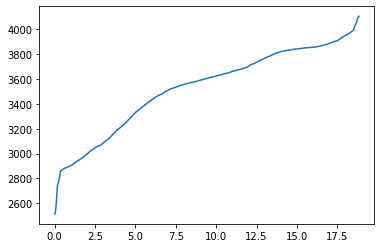

In [ ]:
FullMeans2 = get_means(Fullparam2)
FullMeans3 = get_means(Fullparam3)
print(FullMeans2[1])
print(FullMeans3[1])

# FullVelSum = get_paramsums(Fullparam[1])

FullLevels = get_levels(joints2[28], joints2[0])
plt.plot(choreotime, FullLevels[1])
plt.show()

#fix this, find sacrum idx on 17-joint data FullExpa = get_expandedness(joints2, joints2[28])
FullMeanExpa = np.mean(FullExpa[1], axis=0)
FullTotalExpa = np.sum(FullMeanExpa)
FullVarExpa = np.mean(np.var(FullExpa[1], axis=1))

plt.plot(choreotime, FullMeanExpa)
plt.show()



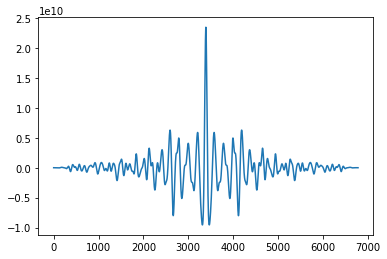

In [ ]:
# 10 on old source

result = np.correlate(lf_sacrumacc2[:,0], lf_sacrumacc2[:,0],mode='full')
plt.plot(result)
plt.show()

#sharpness of first satellite peak ~ how precisely on the beat
#relative height ~ combo of how hard and how precise
#height of central peak also how hard (for accel)
#height of the fourth potential marker for non-beginner (maybe 8 for salseos)
#explicit comparison of bridge vs non-bridge cov - 
#large cross entropy between sequences (distance between autocorr fn)

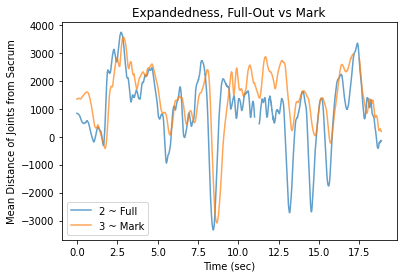

In [ ]:
alljointsfromsacrum2 = from_sacrum(joints2, joints2[28])
alljointsfromsacrum3 = from_sacrum(joints3, joints3[28])

#don't want this mean, want sum of abs of each dim 
meanfromsacrum2 = [j.mean(axis=1) for j in alljointsfromsacrum2]
meanfromsacrum3 = [j.mean(axis=1) for j in alljointsfromsacrum3]

summean2 = sum(meanfromsacrum2)
summean3 = sum(meanfromsacrum3)

plt.plot(choreotime, summean2, alpha=0.7)
plt.plot(choreotime, summean3, alpha=0.7)
plt.xlabel('Time (sec)')
plt.ylabel('Mean Distance of Joints from Sacrum')
plt.title('Expandedness, Full-Out vs Mark')
plt.legend(['2 ~ Full', '3 ~ Mark'])
plt.savefig('Expandedness Full vs Mark')
plt.show()

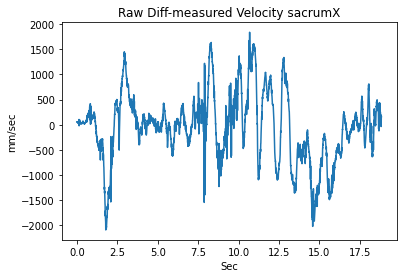

In [ ]:
plt.plot(choreotime, velocitysacrum2[:,0])
plt.title('Raw Diff-measured Velocity sacrumX')
plt.xlabel('Sec')
plt.ylabel('mm/sec')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


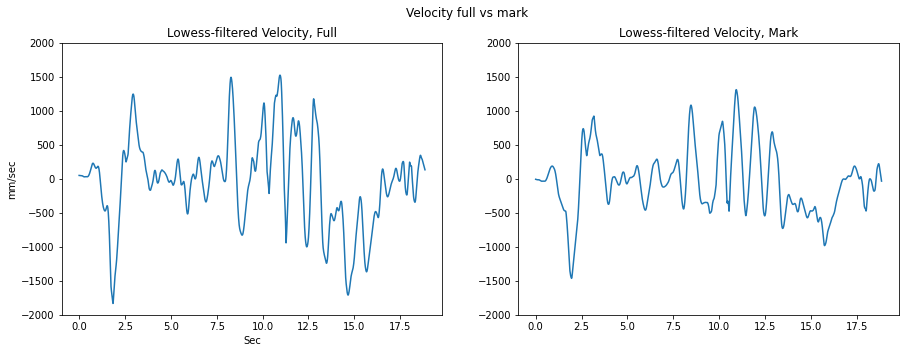

In [ ]:
lf_sacrumvel2 = np.stack((lowess(velocitysacrum2[:,0], choreotime),
                             lowess(velocitysacrum2[:,1], choreotime),
                             lowess(velocitysacrum2[:,2], choreotime)), axis=1)

lf_sacrumvel3 = np.stack((lowess(velocitysacrum3[:,0], choreotime),
                             lowess(velocitysacrum3[:,1], choreotime),
                             lowess(velocitysacrum3[:,2], choreotime)), axis=1)

#plots
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle('Velocity full vs mark')
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(choreotime, lf_sacrumvel2[:,0])
ax1.set_title('Lowess-filtered Velocity, Full')
ax1.set_xlabel('Sec')
ax1.set_ylabel('mm/sec')
ax1.set_ylim(-2000, 2000)
ax2.plot(choreotime, lf_sacrumvel3[:,0])
ax2.set_title('Lowess-filtered Velocity, Mark')
ax2.set_ylim(-2000, 2000)
plt.show()



(-100000.0, 100000.0)

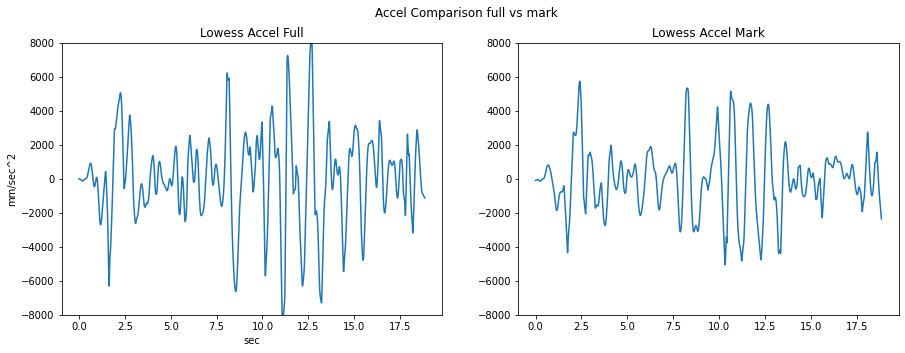

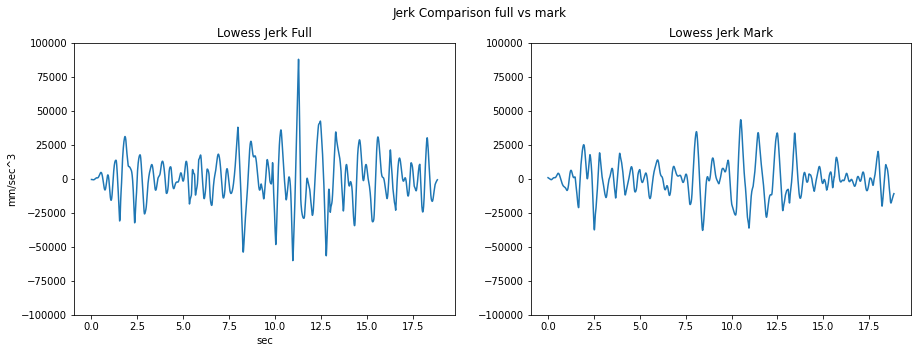

In [ ]:
#Lowess accel

lf_sacrumacc2 = get_accel(lf_sacrumvel2, choreotime)
lf_sacrumacc3 = get_accel(lf_sacrumvel3, choreotime)
 
lf_sacrumacc2 = np.stack((lowess(lf_sacrumacc2[:,0], choreotime),
                          lowess(lf_sacrumacc2[:,1], choreotime),
                          lowess(lf_sacrumacc2[:,2], choreotime)), axis=1)

lf_sacrumacc3 = np.stack((lowess(lf_sacrumacc3[:,0], choreotime),
                          lowess(lf_sacrumacc3[:,1], choreotime),
                          lowess(lf_sacrumacc3[:,2], choreotime)), axis=1)


#Accel Plots
fig, (ax1, ax2) = plt.subplots(1,2) 

fig.suptitle('Accel Comparison full vs mark')
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(choreotime, lf_sacrumacc2[:,0])
ax1.set_ylabel('mm/sec^2')
ax1.set_ylim(-8000, 8000)
ax1.set_xlabel('sec')
ax1.set_title('Lowess Accel Full')
ax2.plot(choreotime, lf_sacrumacc3[:,0])
ax2.set_ylim(-8000, 8000)
ax2.set_title('Lowess Accel Mark')

#Lowess jerk

lf_sacrumjerk2 = get_jerk(lf_sacrumacc2, choreotime)
lf_sacrumjerk3 = get_jerk(lf_sacrumacc3, choreotime)

lf_sacrumjerk2 = np.stack((lowess(lf_sacrumjerk2[:,0], choreotime),
                           lowess(lf_sacrumjerk2[:,1], choreotime),
                           lowess(lf_sacrumjerk2[:,2], choreotime)), axis=1)

lf_sacrumjerk3 = np.stack((lowess(lf_sacrumjerk3[:,0], choreotime),
                           lowess(lf_sacrumjerk3[:,1], choreotime),
                           lowess(lf_sacrumjerk3[:,2], choreotime)), axis=1)

fig, (ax1, ax2) = plt.subplots(1,2) 

#Jerk Plots
fig.suptitle('Jerk Comparison full vs mark')
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(choreotime, lf_sacrumjerk2[:,0])
ax1.set_ylabel('mm/sec^3')
ax1.set_ylim(-100000, 100000)
ax1.set_xlabel('sec')
ax1.set_title('Lowess Jerk Full')
ax2.plot(choreotime, lf_sacrumjerk3[:,0])
ax2.set_title('Lowess Jerk Mark')
ax2.set_ylim(-100000, 100000)



In [ ]:
#Comparing sum of derivative of movement values for Sacrum
sacrum_movetotal2 = np.sqrt(np.sum(lf_sacrumvel2**2))
sacrum_movetotal3 = np.sqrt(np.sum(lf_sacrumvel3**2))

sacrum_acctotal2 = np.sqrt(np.sum(lf_sacrumacc2**2))
sacrum_acctotal3 = np.sqrt(np.sum(lf_sacrumacc3**2))

sacrum_jerktotal2 = np.sqrt(np.sum(lf_sacrumjerk2**2))
sacrum_jerktotal3 = np.sqrt(np.sum(lf_sacrumjerk3**2))

print('fullmove =', sacrum_movetotal2)
print('markmove =', sacrum_movetotal3)
print('fullacc =', sacrum_acctotal2)
print('markacc =', sacrum_acctotal3)
print('fulljerk =', sacrum_jerktotal2)
print('markjerk =', sacrum_jerktotal3)

fullmove = 55000.068554709665
markmove = 40438.53871508422
fullacc = 280851.10094180773
markacc = 189719.1376089012
fulljerk = 2004507.224059998
markjerk = 1288276.948942388


In [ ]:
#get mean, abs, var of the above movement quantities

sacrummove2 = [joints2[28], lf_sacrumvel2, lf_sacrumacc2, lf_sacrumjerk2]
sacrummove3 = [joints3[28], lf_sacrumvel3, lf_sacrumacc3, lf_sacrumjerk3]

meansacrum2 = get_meanmove(sacrummove2)
meansacrum3 = get_meanmove(sacrummove3)

print('means full', meansacrum2)
print('means mark', meansacrum3)  

varsacrum2 = get_varmove(sacrummove2)
varsacrum3 = get_varmove(sacrummove3)

print('vars full', varsacrum2)
print('vars mark', varsacrum3) 

#featurization contains unaligned and aligned elements
#sums, like total jerk ~ unaligned
#similarity to expert trace requires alignment

means full [[ 1.38167085e+02  9.50664117e+02 -1.52941238e+03]
 [-4.62302675e+01  4.37514414e+00 -6.48016012e+01]
 [ 2.25543084e+01  1.42585227e+01  4.26969636e-01]
 [-2.73205090e+02 -4.00052756e+02  2.15119954e+02]]
means mark [[ 2.43458866e+01  9.52687340e+02 -1.46702226e+03]
 [-3.59383097e+01  1.22374849e+00 -5.02195533e+01]
 [-8.92398315e+00  3.15601538e+01  1.61591671e+01]
 [-5.32609787e+01  1.69476301e+02 -1.06913399e+02]]
vars full [[5.87514920e+05 8.87953395e+03 7.76224449e+04]
 [4.15669399e+05 2.31367244e+05 2.37888679e+05]
 [6.91735622e+06 1.18303615e+07 4.49180021e+06]
 [3.02626407e+08 6.81071790e+08 1.99889203e+08]]
vars mark [[2.10001199e+05 5.82628436e+03 4.50232983e+04]
 [2.22962439e+05 1.14291832e+05 1.40744282e+05]
 [3.85021050e+06 4.64587320e+06 2.10757396e+06]
 [1.59377997e+08 2.44693043e+08 8.48834652e+07]]


In [ ]:
#makes sense that mean acc in ydim is higher for mark (though vel is lower) - more passive gravity resistance less freefall / -y_accel

#note full is not more symmetric than mark - net XZ_vel or XZ_accel

#abs of jerk roughly double for full vs mark in all dim. var of all higher for full than mark. Makes sense


In [ ]:
#covariance of R_arm joints with L_arm, and same for legs (multiplied by diff in net movement?)
#should be really swongy? high 2nd deriv?

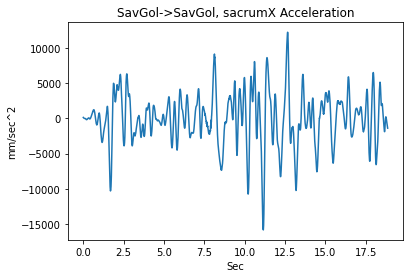

In [ ]:
sgax = savgol(accelsacrumsg[:,0], window=45, order=3)
sgay = savgol(accelsacrumsg[:,1], window=45, order=3)
sgaz = savgol(accelsacrumsg[:,2], window=45, order=3)

savgolsacrumacc = np.stack((sgax, sgay, sgaz), axis=1)
plt.plot(choreotime, savgolsacrumacc[:,0])
plt.title('SavGol->SavGol, sacrumX Acceleration')
plt.xlabel('Sec')
plt.ylabel('mm/sec^2')
plt.show()

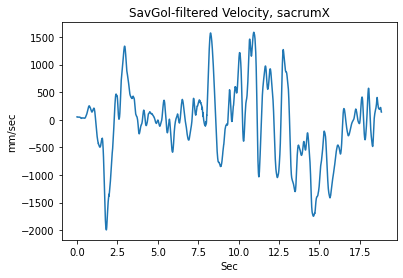

In [ ]:
savgol_sacrumvelx = savgol(velocitysacrumtest[:,0])
plt.plot(choreotime, savgol_sacrumvelx)
plt.title('SavGol-filtered Velocity, sacrumX')
plt.xlabel('Sec')
plt.ylabel('mm/sec')
plt.show()

savgol_sacrumvel = np.stack((savgol(velocitysacrumtest[:,0]), savgol(velocitysacrumtest[:,1]), savgol(velocitysacrumtest[:,2])), axis=1)

In [ ]:
#comparing acceleration measures - Lowess wins
rawaccel = get_accel(velocitysacrum, choreotime)

accelsacruml = get_accel(lowess_sacrumvel, choreotime)

accelsacrumsg = get_accel(savgol_sacrumvel, choreotime)

fig, (ax1, ax2, ax3) = plt.subplots(1,3) 

fig.suptitle('Acceleration preproc sacrumX')
fig.set_figheight(5)
fig.set_figwidth(20)
ax1.plot(choreotime, rawaccel[:,0])
ax1.set_title('Raw->Raw')
ax2.plot(choreotime, accelsacruml[:,0])
ax2.set_title('Lowess->Raw')
ax3.plot(choreotime, accelsacrumsg[:,0])
ax3.set_title('SavGol->Raw')
plt.show()

NameError: ignored

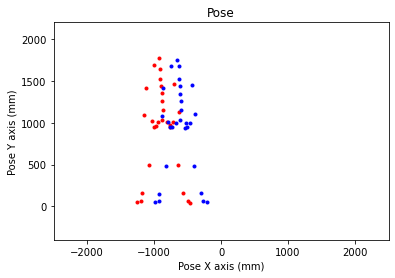

In [ ]:
#animate plot of choreo2 joints (red) and choreo3 joints (blue)

#initialize empty data lists and make labels + colors
x1,y1 = [],[]
x2,y2 = [],[]

fig = plt.figure()
ax1 = plt.axes(xlim=(-2500, 2500), ylim=(-400,2200))
line, = ax1.plot([], [])
plt.xlabel('Pose X axis (mm)')
plt.ylabel('Pose Y axis (mm)')
plt.title('Pose')

plotlays, plotcols = [2], ["r.","b."]
lines = []

for index in range(2):
    lobj = ax1.plot([],[], plotcols[index])[0]
    lines.append(lobj)

anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=3394, interval=15, blit=True)
anim.save('Full vs Mark.mp4')

plt.show()

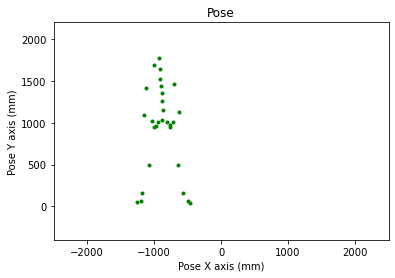

In [ ]:
#animate plot of choreo2

fig, ax = plt.subplots()
xs, ys = [], []
ln, = plt.plot([], [], 'g.', animated=True)

def init():
    ax.set_xlim(-2500, 2500)
    ax.set_ylim(-400, 2200)
    ax.set_xlabel('Pose X axis (mm)')
    ax.set_ylabel('Pose Y axis (mm)')
    plt.title('Pose')
    return ln,
    
def update(frame):
    xs = [choreo2df.iloc[startframe+frame, j] for j in range (2,89,3)]
    ys = [choreo2df.iloc[startframe+frame, j] for j in range (3,89,3)]
    ln.set_data(xs, ys)
    return ln,

choreo2 = FuncAnimation(fig, update, frames=3394, init_func=init, interval=20, blit=True)
choreo2.save('choreo2.mp4')
plt.show()

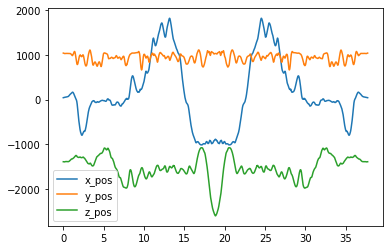

In [ ]:
dub_sacrumpos2, doubletime = flipitandreverseit(sacrumpos2, choreotime)

plt.plot(doubletime, dub_sacrumpos2)
plt.legend(dub_sacrumpos2.columns)
plt.show()           

C:\Users\TBenB\miniconda3\envs\aenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\TBenB\miniconda3\envs\aenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\TBenB\miniconda3\envs\aenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


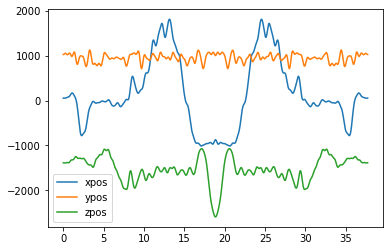

In [ ]:
#get velocities of fourier-filtered sacrumdimensions, need to filter the dimensions separately it seems like
n = 2*len(choreotime)
sacrumfft = [np.fft.fft(dub_sacrumpos2.iloc[:, 0]),
             np.fft.fft(dub_sacrumpos2.iloc[:, 1]),
             np.fft.fft(dub_sacrumpos2.iloc[:, 2])]
dt = choreotime[1]-choreotime[0]
freq = fftpack.fftfreq(n, d=dt)


high_freq_fft = sacrumfft.copy()
for dimension in high_freq_fft:
    dimension[np.abs(freq) > 2] = 0 
filtered_sacrum = fftpack.ifft([dimension for dimension in high_freq_fft])

#dfiltered_sacrum_x = pd.Dataframe(data=filtered_sacrum_x, columns)

#filtered_sacrumvel = pd.Dataframe(#concatenate array of XvelYvelZvel here, columns=['x_vel', 'y_vel', 'z_vel'])

plt.plot(doubletime, filtered_sacrum[0])
plt.plot(doubletime, filtered_sacrum[1])
plt.plot(doubletime, filtered_sacrum[2])
plt.legend(['xpos', 'ypos', 'zpos'])
plt.show()

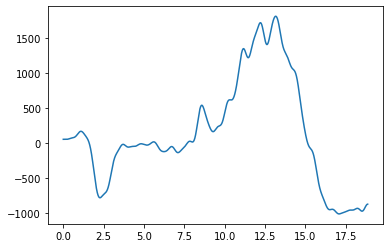

<ipython-input-85-f8592718310a>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  f_sacrumpos2.x_vel = test
<ipython-input-85-f8592718310a>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  f_sacrumpos2.y_vel = filtered_sacrum[1].real
<ipython-input-85-f8592718310a>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  f_sacrumpos2.z_vel = filtered_sacrum[2].real


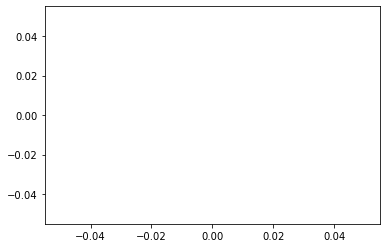

In [ ]:
test = filtered_sacrum[0].real
plt.plot(choreotime, filtered_sacrum[0].real[:len(choreotime)])
plt.show()

f_sacrumpos2 = pd.DataFrame(index=range(len(doubletime)),
                            columns=['x_pos', 'y_pos', 'z_pos'])
f_sacrumpos2.x_vel = test
f_sacrumpos2.y_vel = filtered_sacrum[1].real
f_sacrumpos2.z_vel = filtered_sacrum[2].real

f_sacrumvel2 = get_velocity(f_sacrumpos2, doubletime)
plt.plot(doubletime, f_sacrumvel2.x_vel)
plt.show()

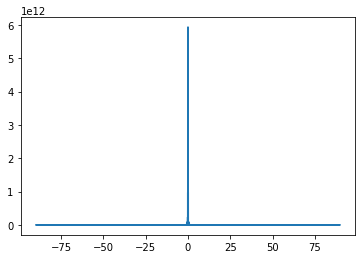

C:\Users\TBenB\miniconda3\envs\aenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


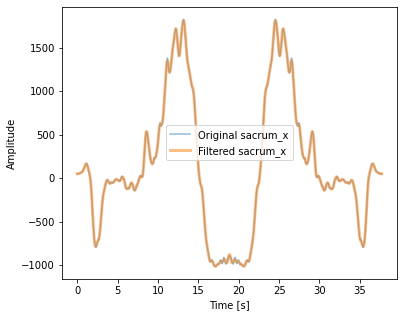

In [ ]:
#fourier transform

n = 2*len(choreotime)
sacrumfft_x = np.fft.fft(dub_sacrumpos2.iloc[:,0],n)
sacrumpow_x = np.abs(sacrumfft_x)**2
dt = choreotime[1]-choreotime[0]
freq = fftpack.fftfreq(n, d=dt)

plt.plot(freq, sacrumpow_x)
plt.show()

high_freq_fft = sacrumfft_x.copy()
high_freq_fft[np.abs(freq) > 2] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(doubletime, dub_sacrumpos2.iloc[:,0], alpha=0.5, label='Original sacrum_x')
plt.plot(doubletime, filtered_sig, linewidth=3, alpha=0.5, label='Filtered sacrum_x')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')

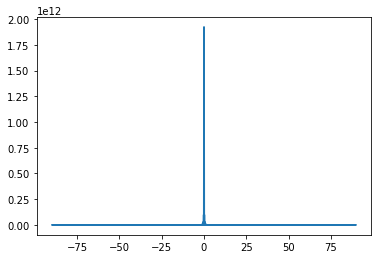

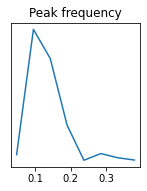

C:\Users\TBenB\miniconda3\envs\aenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


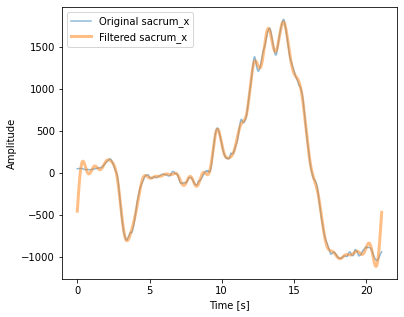

In [ ]:
#fourier transform
n = len(choreotime)
sacrumfft = np.fft.fft(sacrumpos2.iloc[:,0],n)
sacrumpow = np.abs(sacrumfft)**2
dt = choreotime[1]-choreotime[0]
freq = fftpack.fftfreq(n, d=dt)

plt.plot(freq, sacrumpow)
plt.show()

pos_mask = np.where(freq > 0)
freqs = freq[pos_mask]
peak_freq = freqs[sacrumpow[pos_mask].argmax()]

axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], sacrumpow[:8])
plt.setp(axes, yticks=[])
plt.show()

high_freq_fft = sacrumfft.copy()
high_freq_fft[np.abs(freq) > 1.21] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(6, 5))
plt.plot(choreotime, sacrumpos2.iloc[:,0], alpha=0.5, label='Original sacrum_x')
plt.plot(choreotime, filtered_sig, linewidth=3, alpha=0.5, label='Filtered sacrum_x')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')

<function matplotlib.pyplot.show(close=None, block=None)>

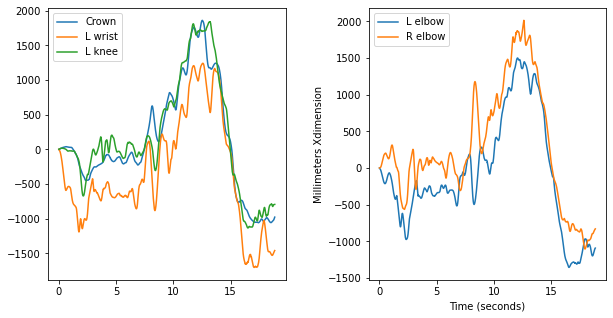

In [ ]:
#what to plot next? spineposes? Right vs left? 

#std dev of POS/VEL/ACC?

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(choreo2df.Time_sec, choreo2df.crown_x)
plt.plot(choreo2df.Time_sec, choreo2df.L_wrist_x)
plt.plot(choreo2df.Time_sec, choreo2df.L_knee_x)
plt.legend(['Crown', 'L wrist', 'L knee'])

plt.subplot(1,2,2)
plt.plot(choreo2df.Time_sec, choreo2df.L_elbow_x)
plt.plot(choreo2df.Time_sec, choreo2df.R_elbow_x)
plt.legend(['L elbow', 'R elbow'])

plt.subplots_adjust(wspace=.35)
plt.savefig('jointpose plots 1.png')
plt.xlabel('Time (seconds)')
plt.ylabel('Millimeters Xdimension')
plt.show




In [ ]:
#shift to zero on first frame - don't use for representing whole-body frame
#choreo2df = choreo2df.iloc[startframe:endframe, 1:].reset_index()
#choreo2df.iloc[:, 2:] -= choreo2df.iloc[0,:]
#choreo2df.Time_sec -= choreo2df.Time_sec[0]
#choreo2df.head()

,index,Time_sec,crown_x,crown_y,crown_z,rtemple_x,rtemple_y,rtemple_z,L_shoulder_x,L_shoulder_y,...,spine4_z,spine5_x,spine5_y,spine5_z,occiput_x,occiput_y,occiput_z,sacrum_x,sacrum_y,sacrum_z
0,1664,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1665,0.005556,0.095360,-0.236328,0.774414,0.354313,-0.509399,0.630982,0.865661,-1.421631,...,0.791870,0.584031,-0.460693,1.428711,0.649933,-0.348877,1.048584,0.321629,-0.410400,-0.201783
2,1666,0.011112,0.181701,-0.513061,1.592773,0.709763,-1.007812,1.206421,1.739929,-2.899658,...,1.867309,0.843758,-0.964844,2.879028,1.289925,-0.704712,1.951904,0.656010,-0.885986,-0.411988
3,1667,0.016667,0.288456,-0.691162,2.346679,1.189969,-1.563842,1.862793,2.716614,-4.388184,...,3.046387,1.265164,-1.479981,4.419311,1.910519,-1.173096,2.911987,0.979614,-1.312988,-0.590821
4,1668,0.022223,0.444103,-0.935669,3.168701,1.584050,-2.043579,2.507935,3.570770,-6.063965,...,4.015625,1.658875,-2.057617,5.762207,2.490551,-1.565186,3.940429,1.231240,-1.665649,-0.751709


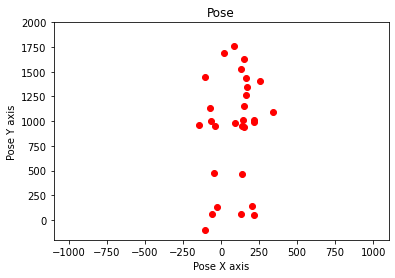

In [ ]:
#first test animation

fig, ax = plt.subplots()
xs, ys = [], []
ln, = plt.plot([], [], 'ro', animated=True)

def init():
    ax.set_xlim(-1100, 1100)
    ax.set_ylim(-200, 2000)
    ax.set_xlabel('Pose X axis')
    ax.set_ylabel('Pose Y axis')
    plt.title('Pose')
    return ln,

def update(frame):
    xs = [choreo2df.iloc[startframe+frame, j] for j in range (2,89,3)]
    ys = [choreo2df.iloc[startframe+frame, j] for j in range (3,89,3)]
    ln.set_data(xs, ys)
    return ln,

ani = FuncAnimation(fig, update, frames=180,
                    init_func=init, blit=True)
ani.save('first movement&.mp4')
plt.show()

In [ ]:
# jointmodel = [xpos, ypos, zpos, xvel, yvel, zvel, xacc, yacc, zacc]

frame = 0
dt = 1/180
x_vel, y_vel, z_vel = 0, 0, 0
x_acc, y_acc, z_acc = 0, 0, 0

jointmodel = np.array([[1 + x_vel*dt, 0, 0, dt, 0, 0, dt**2/2, 0, 0],
                        [0, 1 + y_vel*dt, 0, 0, dt, 0, 0, dt**2/2, 0], 
                        [0, 0, 1 + z_vel*dt, 0, 0, dt, 0, 0, dt**2/2],
                        [0, 0, 0, 1 + x_acc*dt, 0, 0, dt, 0, 0],
                        [0, 0, 0, 0, 1 + y_acc*dt, 0, 0, dt, 0],
                        [0, 0, 0, 0, 0, 1 + z_acc*dt, 0, 0, dt],
                        [0, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 1]
        ])

x0s = [choreo2df.iloc[startframe+frame, j] for j in range (2,89,3)]
y0s = [choreo2df.iloc[startframe+frame, j] for j in range (3,89,3)]
z0s = [choreo2df.iloc[startframe+frame, j] for j in range (4,89,3)]

# 9 state vars. 1-3 = startframe jointposes, 4-9 are initially 0's vel and acc
init_state = np.array([[x0s, y0s, z0s, 
                        np.zeros(29), np.zeros(29), np.zeros(29), 
                        np.zeros(29), np.zeros(29), np.zeros(29)]])

#covariance matrix. initial var estimates for each state value on diag. 
# assuming 0 covariance (false...think about guesses? accel along Xdim is -corr with vel and accel on Y and Zdim?)
state_cov = np.diag([10, 10, 10, 10, 10, 10, 10, 10, 10])

#process model noise - shakey guesswork here
proc_noise = np.diag([1, 1, 1, .1, .1, .1, .01, .01, .01])

#measure noise could depend on expandedness or velocity?
measurement_noise =  np.diag([.2, .2, .2])

observ_matrix = np.diag([1, 1, 1, 0, 0, 0, 0, 0, 0])

#estimation uncertainty = np.diag([?, ?, ?, ?, ?, ?, ?, ?, ?]) smthg like state cov?

estim_cov = np.diag([10, 10, 10, 10, 10, 10, 10, 10, 10])


#measurements from choreo2df[frame] or alljoints[frame]
#residualss = []
#for joint in alljoints2:
 #   residuals[joint][frame] = [choreo2df.iloc[frame, :] - observ_matrix @ pred_state + measurement_noise for frame in frames] 

    
            #jointupdate = modelpredict + var *(measurement - modelpredict)
                
            #K gain = estimuncertainty / estimuncertainty + measureuncertainty
              
            


In [ ]:
kf = KalmanFilter (dim_x=9, dim_z=3)
#initial state
kf.x = init_state
#state transition
kf.F = jointmodel
#measurement
kf.H = observ_matrix
#covariance (estim uncertainty) lower this
kf.P = estim_cov
#measurement uncertainty
kf.R = measurement_noise
#process uncertainty
kf.Q = proc_noise
    

#should I define a function that takes a joint as a parameter 
#and does the kf on that joint? 
    
#loop through frames ~ while loop with index < endframe-startframe:
#frame = 0
#filtered = []

#while frame < len(frames): 
 #   z = get_sensor_reading()
  #  kf.predict()
   # kf.update(z)
   # filtered.append(kf.x)
#    frame += 1
    

In [ ]:
#create dfs for the x, y, and z per each joint

#from choreo2
crownpos2 = choreo2df.iloc[startframe:endframe, 2:5]
rtemplepos2 = choreo2df.iloc[startframe:endframe, 5:8]
L_shoulderpos2 = choreo2df.iloc[startframe:endframe, 8:11]
L_anklepos2 = choreo2df.iloc[startframe:endframe, 11:14]
L_btoepos2 = choreo2df.iloc[startframe:endframe, 14:17]
L_elbowpos2 = choreo2df.iloc[startframe:endframe, 17:20]
L_hippantpos2 = choreo2df.iloc[startframe:endframe, 20:23]
L_hiplatpos2 = choreo2df.iloc[startframe:endframe, 23:26]
L_hippospos2 = choreo2df.iloc[startframe:endframe, 26:29] 
L_kneepos2 = choreo2df.iloc[startframe:endframe, 29:32]
L_ltoepos2 = choreo2df.iloc[startframe:endframe, 32:35]
L_wristpos2 = choreo2df.iloc[startframe:endframe, 35:38]
R_shoulderpos2 = choreo2df.iloc[startframe:endframe, 38:41]
R_anklepos2 = choreo2df.iloc[startframe:endframe, 41:44]
R_btoepos2 = choreo2df.iloc[startframe:endframe, 44:47] 
R_elbowpos2 = choreo2df.iloc[startframe:endframe, 47:50]
R_hipantpos2 = choreo2df.iloc[startframe:endframe, 50:53]
R_hiplatpos2 = choreo2df.iloc[startframe:endframe, 53:56]
R_hippospos2 = choreo2df.iloc[startframe:endframe, 56:59]
R_kneepos2 = choreo2df.iloc[startframe:endframe, 59:62]
R_ltoepos2 = choreo2df.iloc[startframe:endframe, 62:65]
R_wristpos2 = choreo2df.iloc[startframe:endframe, 65:68]
spine1pos2 = choreo2df.iloc[startframe:endframe, 68:71] 
spine2pos2 = choreo2df.iloc[startframe:endframe, 71:74]
spine3pos2 = choreo2df.iloc[startframe:endframe, 74:77]
spine4pos2 = choreo2df.iloc[startframe:endframe, 77:80]
spine5pos2 = choreo2df.iloc[startframe:endframe, 80:83]
occiputpos2 = choreo2df.iloc[startframe:endframe, 83:86]
sacrumpos2 = choreo2df.iloc[startframe:endframe, 86:89]

#make an alljoints variable = list of the above?
alljoints2 = [crownpos2, rtemplepos2, L_shoulderpos2, L_anklepos2, L_btoepos2, L_elbowpos2, L_hippantpos2, L_hiplatpos2, L_hippospos2, L_kneepos2, L_ltoepos2, L_wristpos2, R_shoulderpos2, R_anklepos2, R_btoepos2, R_elbowpos2, R_hipantpos2, R_hiplatpos2, R_hippospos2, R_kneepos2, R_ltoepos2, R_wristpos2, spine1pos2, spine2pos2, spine3pos2, spine4pos2, spine5pos2, occiputpos2, sacrumpos2]

sacrumpos2.head()

,sacrum_x,sacrum_y,sacrum_z
1664,45.824085,1045.835693,-1388.551147
1665,46.145714,1045.425293,-1388.752930
1666,46.480095,1044.949707,-1388.963135
1667,46.803699,1044.522705,-1389.141968
1668,47.055325,1044.170044,-1389.302856


In [ ]:
#joints from choreo3
crownpos3 = choreo3df.iloc[startframe:endframe, 2:5]
rtemplepos3 = choreo3df.iloc[startframe:endframe, 5:8]
L_shoulderpos3 = choreo3df.iloc[startframe:endframe, 8:11]
L_anklepos3 = choreo3df.iloc[startframe:endframe, 11:14]
L_btoepos3 = choreo3df.iloc[startframe:endframe, 14:17]
L_elbowpos3 = choreo3df.iloc[startframe:endframe, 17:20]
L_hippantpos3 = choreo3df.iloc[startframe:endframe, 20:23]
L_hiplatpos3 = choreo3df.iloc[startframe:endframe, 23:26]
L_hippospos3 = choreo3df.iloc[startframe:endframe, 26:29] 
L_kneepos3 = choreo3df.iloc[startframe:endframe, 29:32]
L_ltoepos3 = choreo3df.iloc[startframe:endframe, 32:35]
L_wristpos3 = choreo3df.iloc[startframe:endframe, 35:38]
R_shoulderpos3 = choreo3df.iloc[startframe:endframe, 38:41]
R_anklepos3 = choreo3df.iloc[startframe:endframe, 41:44]
R_btoepos3 = choreo3df.iloc[startframe:endframe, 44:47] 
R_elbowpos3 = choreo3df.iloc[startframe:endframe, 47:50]
R_hipantpos3 = choreo3df.iloc[startframe:endframe, 50:53]
R_hiplatpos3 = choreo3df.iloc[startframe:endframe, 53:56]
R_hippospos3 = choreo3df.iloc[startframe:endframe, 56:59]
R_kneepos3 = choreo3df.iloc[startframe:endframe, 59:62]
R_ltoepos3 = choreo3df.iloc[startframe:endframe, 62:65]
R_wristpos3 = choreo3df.iloc[startframe:endframe, 65:68]
spine1pos3 = choreo3df.iloc[startframe:endframe, 68:71] 
spine2pos3 = choreo3df.iloc[startframe:endframe, 71:74]
spine3pos3 = choreo3df.iloc[startframe:endframe, 74:77]
spine4pos3 = choreo3df.iloc[startframe:endframe, 77:80]
spine5pos3 = choreo3df.iloc[startframe:endframe, 80:83]
occiputpos3 = choreo3df.iloc[startframe:endframe, 83:86]
sacrumpos3 = choreo3df.iloc[startframe:endframe, 86:89]

alljoints3 = [crownpos3, rtemplepos3, L_shoulderpos3, L_anklepos3, L_btoepos3, L_elbowpos3, L_hippantpos3, L_hiplatpos3, L_hippospos3, L_kneepos3, L_ltoepos3, L_wristpos3, R_shoulderpos3, R_anklepos3, R_btoepos3, R_elbowpos3, R_hipantpos3, R_hiplatpos3, R_hippospos3, R_kneepos3, R_ltoepos3, R_wristpos3, spine1pos3, spine2pos3, spine3pos3, spine4pos3, spine5pos3, occiputpos3, sacrumpos3]



### AutoSKLearn for Dance Genre Classification Task

Given a set of time series pose data, can we train a model to accurately predict the genre of new data?

In [ ]:
# Install auto-sklearn and update scipy:
!sudo apt-get install build-essential swig
!pip install auto-sklearn
!pip install --upgrade scipy

In [ ]:
# Import packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import autosklearn.classification

In [ ]:
# Load data